# Imports

In [30]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import torch
from torch.autograd import Variable   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import linecache
import pandas as pd
from sklearn import preprocessing
from tqdm import trange
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.cuda.set_device(2)
import time
import math

# Help functions

In [31]:
def line_show(line_batch, text=None):
    batch = line_batch["line"][0].shape[0]
    line1 = line_batch["line"][0].numpy().reshape(batch,-1)
    line2 = line_batch["line"][1].numpy().reshape(batch,-1)
    label = line_batch["label"].numpy()
    for i in range(batch):
        ax = plt.subplot(batch/2, 2, i+1)
        plt.subplots_adjust(wspace=0.2, hspace=1.5)
        plt.plot(line1[i])
        plt.plot(line2[i])
        plt.axis
        if text:
            ax.set_title(text+str(label[i]),fontsize=12,color='r')
    
def line_show_test(line_batch, text=None):
    line1 = line_batch[0].numpy().reshape(1,-1)
    line2 = line_batch[1].numpy().reshape(1,-1)
    plt.figure()
    plt.plot(line1[0])
    plt.plot(line2[0])
    if text:
        plt.title(text,fontsize='large',fontweight='bold') 
        
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
    
def read_data_row(path, num):       
    return linecache.getline(path,num)

def normalization(l1, l2):
    pass

# Configuration Class

In [32]:
class Config():
    training_dir = "./data/train/"
    testing_dir = "./data/test/"
    train_batch_size = 32
    train_number_epochs = 30
    train_lr = 0.001
    train_m = 10.0

# Custom Dataset Class

In [33]:
class SkylineDataset(Dataset):
    
    def __init__(self,root,transform=None):
        self.root_path = root
        self.transform = transform
        self.filenames = os.listdir(self.root_path)
    def __getitem__(self,idx):
        filename = self.filenames[idx]
        file = read_data_row(os.path.join(self.root_path, filename), 1).strip().split(" ")
        line1 = np.array(list(map(int, file[0].split(',')))) # C*H*W = (1, 300, 1)
        if self.transform:
            line1 = Move()(line1)
            line1 = Rotate()(line1)
        line2 = np.array(list(map(int, file[1].split(','))))
        line = np.hstack((line1, line2))
        
        line_min, line_max = line.min(), line.max()
        line = (line-line_min)/(line_max-line_min)
        
        line1 = line[:300].reshape(1, 300, 1)
        line2 = line[300:].reshape(1, 300, 1)
        label = np.array(list(map(int, file[2])))
        sample = {"line":[line1, line2], "label":label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def __len__(self):
        return len(self.filenames)
    

In [34]:
class Rotate(object):
    def __call__(self, line):
        angle = random.randint(-6,6)
        pointx = len(line)//2
        pointy = line[pointx]
        angle = float(angle) * 3.1415  / float(180)
        x = np.arange(len(line))
        y = (x-pointx) * math.sin(angle) + (line - pointy) * math.cos(angle) + pointy
        
        return y


class Move(object):
    def __call__(self, line):
        delta = random.randint(-20,20)
        return line + delta
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        line, lable = sample['line'], sample['label']
        return {'line': [torch.from_numpy(line[0]).float(), torch.from_numpy(line[1]).float()],
                'label': torch.from_numpy(lable).float()}

In [35]:
# show
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))


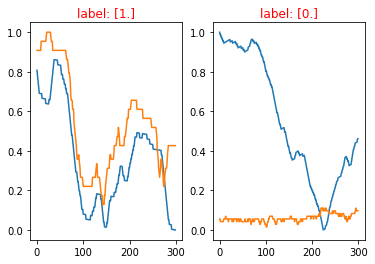

In [36]:
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = 2,
                       num_workers = 0
                       )
dataiter = iter(train_dataloader)
example_batch = next(dataiter)
line_show(example_batch, text="label: ")

# Neural Net Definition

In [37]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv1d(1, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(48),
            nn.MaxPool1d(kernel_size=2, stride=2), # 48*150
            
            nn.Conv1d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2, stride=2), # 128*75
            
            nn.Conv1d(128, 1, kernel_size=5, stride=2),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(1) # 1*36
        )
        
           
        
        self.classify = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=2, stride=2),  # N*4*18
            
             nn.Conv1d(8, 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.BatchNorm1d(2),
            nn.MaxPool1d(kernel_size=2, stride=2)  # N*2*9
        )
        

        self.fc = nn.Sequential(
            nn.Linear(18, 1),
            nn.Sigmoid())

    def forward_once(self, x):

        output = self.feature(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        output = torch.cat((output1, output2), 1)

        output = self.classify(output)

        output = output.view(-1, 1, 18).contiguous()

        output = self.fc(output)
        return output


In [38]:
from tensorboardX import SummaryWriter
dummy_input0 = torch.rand(32,1, 300) 
dummy_input1 = torch.rand(32,1, 300) 
model = SiameseNetwork()
with SummaryWriter(comment='SiameseNetwork') as w:
    w.add_graph(model, (dummy_input0, dummy_input1))

# Loss

In [39]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        euclidean_distance = F.threshold(euclidean_distance, 0.1, 0.0, inplace=False)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)) # 所有batch的loss

        return loss_contrastive

# Train

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
skyline_dataset = SkylineDataset(root=Config.training_dir, 
                                transform=transforms.Compose([ToTensor()]))
train_dataloader = DataLoader(skyline_dataset, 
                       shuffle=True,
                       batch_size = Config.train_batch_size,
                       num_workers = 0
                       )

In [42]:
net = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(),lr = Config.train_lr)

In [43]:
counter = []
loss_history = [] 
iteration_number= 0
best_acc = 0

In [44]:
def train(echoh):
    net.train()
    for i, data in enumerate(train_dataloader,0):
        line1 = data["line"][0].view(Config.train_batch_size, 1, -1)
        line2 = data["line"][1].view(Config.train_batch_size, 1, -1)
        label = data["label"]
        line1, line2 , label = line1.to(device), line2.to(device) , label.to(device)
        optimizer.zero_grad()
        output = net(line1,line2)
        loss_contrastive = criterion(output,label)
        loss_contrastive.backward()
        optimizer.step()
        
        if i %100 == 0 :
            print("Epoch {} | {} | Current loss {} ".format(epoch, i, loss_contrastive.item()))

In [45]:
def test(epoch):
    net.eval()
    
    with torch.no_grad():
        filenames = os.listdir(Config.testing_dir)
        acc_top20 = 0
        acc_top50 = 0
        acc_top100 = 0
        acc_top200 = 0
        
        for i in trange(100):
            index_target = random.randint(0, len(filenames)-1)
            file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
            line0 = np.array(list(map(int, file0[0].split(','))))
            dist = []
            for f in filenames:
                file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
                line1 = np.array(list(map(int, file1[1].split(','))))
                line = np.hstack((line0, line1))
                line_min, line_max = line.min(), line.max()
                line = (line-line_min)/(line_max-line_min)
                line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
                line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))
                
                output = net(Variable(line1).float().to(device), Variable(line2).float().to(device))
                dist.append(output.item())

            dist = pd.Series(np.array(dist)).sort_values(ascending=False)
            if index_target in dist[:20].index.tolist():
                acc_top20 += 1
            if index_target in dist[:50].index.tolist():
                acc_top50 += 1    
            if index_target in dist[:100].index.tolist():
                acc_top100 += 1
            if index_target in dist[:200].index.tolist():
                acc_top200 += 1
                
        acc_top20 /= 100.0
        acc_top50 /= 100.0
        acc_top100 /= 100.0
        acc_top200 /= 100.0
        acc_mean = (acc_top20+acc_top50+acc_top100+acc_top200) / 4
        print('epoch %d | acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f' % (epoch, 
                                                                                                    acc_top20, 
                                                                                                    acc_top50,
                                                                                                    acc_top100,
                                                                                                    acc_top200,
                                                                                                    acc_mean))
        
        # saving
        global best_acc
        if acc_mean > best_acc:
            print("saving...")
            if not os.path.isdir('./checkpoint'):
                os.mkdir('./checkpoint')
            time_str = time.strftime("%Y-%m-%d %X",time.localtime())
            torch.save(net.state_dict(), './checkpoint/ckpt.{}.{:.2f}.pth'.format(time_str, acc_mean))
            best_acc = acc_mean
    

In [46]:
for epoch in range(0,30):
    train(epoch)
    test(epoch)

Epoch 0 | 0 | Current loss 0.690406084060669 
Epoch 0 | 100 | Current loss 0.6844340562820435 
Epoch 0 | 200 | Current loss 0.6922391653060913 
Epoch 0 | 300 | Current loss 0.6886725425720215 
Epoch 0 | 400 | Current loss 0.6501508951187134 
Epoch 0 | 500 | Current loss 0.6078806519508362 
Epoch 0 | 600 | Current loss 0.5861471891403198 
Epoch 0 | 700 | Current loss 0.6012499928474426 
Epoch 0 | 800 | Current loss 0.5646170377731323 
Epoch 0 | 900 | Current loss 0.5484395623207092 
Epoch 0 | 1000 | Current loss 0.5497540235519409 
Epoch 0 | 1100 | Current loss 0.44562315940856934 
Epoch 0 | 1200 | Current loss 0.5146162509918213 
Epoch 0 | 1300 | Current loss 0.4343808889389038 
Epoch 0 | 1400 | Current loss 0.4932984709739685 
Epoch 0 | 1500 | Current loss 0.36604684591293335 
Epoch 0 | 1600 | Current loss 0.48774272203445435 
Epoch 0 | 1700 | Current loss 0.35726112127304077 
Epoch 0 | 1800 | Current loss 0.3550543785095215 
Epoch 0 | 1900 | Current loss 0.3168565630912781 
Epoch 0 |

Epoch 0 | 16200 | Current loss 0.4016346037387848 
Epoch 0 | 16300 | Current loss 0.19674409925937653 
Epoch 0 | 16400 | Current loss 0.18806177377700806 
Epoch 0 | 16500 | Current loss 0.2848883867263794 
Epoch 0 | 16600 | Current loss 0.30497556924819946 
Epoch 0 | 16700 | Current loss 0.2255498170852661 
Epoch 0 | 16800 | Current loss 0.15638059377670288 
Epoch 0 | 16900 | Current loss 0.42247575521469116 
Epoch 0 | 17000 | Current loss 0.266701877117157 
Epoch 0 | 17100 | Current loss 0.21437333524227142 
Epoch 0 | 17200 | Current loss 0.29773038625717163 
Epoch 0 | 17300 | Current loss 0.1537509560585022 
Epoch 0 | 17400 | Current loss 0.20512676239013672 
Epoch 0 | 17500 | Current loss 0.38573184609413147 
Epoch 0 | 17600 | Current loss 0.4236963391304016 
Epoch 0 | 17700 | Current loss 0.18900074064731598 
Epoch 0 | 17800 | Current loss 0.33708733320236206 
Epoch 0 | 17900 | Current loss 0.3262706398963928 
Epoch 0 | 18000 | Current loss 0.26196521520614624 
Epoch 0 | 18100 | Cu

100%|██████████| 100/100 [03:50<00:00,  2.29s/it]


epoch 0 | acc_top20: 0.740 | acc_top50: 0.890 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.895
saving...
Epoch 1 | 0 | Current loss 0.22560375928878784 
Epoch 1 | 100 | Current loss 0.2929426431655884 
Epoch 1 | 200 | Current loss 0.4555375576019287 
Epoch 1 | 300 | Current loss 0.12879693508148193 
Epoch 1 | 400 | Current loss 0.5250267386436462 
Epoch 1 | 500 | Current loss 0.3177606165409088 
Epoch 1 | 600 | Current loss 0.14883127808570862 
Epoch 1 | 700 | Current loss 0.1454598307609558 
Epoch 1 | 800 | Current loss 0.3157334327697754 
Epoch 1 | 900 | Current loss 0.21236777305603027 
Epoch 1 | 1000 | Current loss 0.28213632106781006 
Epoch 1 | 1100 | Current loss 0.3710838556289673 
Epoch 1 | 1200 | Current loss 0.27209997177124023 
Epoch 1 | 1300 | Current loss 0.22065430879592896 
Epoch 1 | 1400 | Current loss 0.18899419903755188 
Epoch 1 | 1500 | Current loss 0.12899275124073029 
Epoch 1 | 1600 | Current loss 0.2325778603553772 
Epoch 1 | 1700 | Current loss 0.2838511

Epoch 1 | 15900 | Current loss 0.112775519490242 
Epoch 1 | 16000 | Current loss 0.2899460196495056 
Epoch 1 | 16100 | Current loss 0.4692147672176361 
Epoch 1 | 16200 | Current loss 0.22017180919647217 
Epoch 1 | 16300 | Current loss 0.3474210798740387 
Epoch 1 | 16400 | Current loss 0.1629263013601303 
Epoch 1 | 16500 | Current loss 0.31103116273880005 
Epoch 1 | 16600 | Current loss 0.16622400283813477 
Epoch 1 | 16700 | Current loss 0.3892698884010315 
Epoch 1 | 16800 | Current loss 0.148583322763443 
Epoch 1 | 16900 | Current loss 0.3491131067276001 
Epoch 1 | 17000 | Current loss 0.25619804859161377 
Epoch 1 | 17100 | Current loss 0.2091493010520935 
Epoch 1 | 17200 | Current loss 0.3393741846084595 
Epoch 1 | 17300 | Current loss 0.18564018607139587 
Epoch 1 | 17400 | Current loss 0.16287213563919067 
Epoch 1 | 17500 | Current loss 0.35185056924819946 
Epoch 1 | 17600 | Current loss 0.29322996735572815 
Epoch 1 | 17700 | Current loss 0.15868757665157318 
Epoch 1 | 17800 | Curren

100%|██████████| 100/100 [04:26<00:00,  2.65s/it]


epoch 1 | acc_top20: 0.770 | acc_top50: 0.890 | acc_top100: 0.980 | acc_top200: 1.000 | acc_mean: 0.910
saving...
Epoch 2 | 0 | Current loss 0.22156621515750885 
Epoch 2 | 100 | Current loss 0.08461546152830124 
Epoch 2 | 200 | Current loss 0.5632429122924805 
Epoch 2 | 300 | Current loss 0.32667315006256104 
Epoch 2 | 400 | Current loss 0.20964449644088745 
Epoch 2 | 500 | Current loss 0.19906453788280487 
Epoch 2 | 600 | Current loss 0.3527681827545166 
Epoch 2 | 700 | Current loss 0.5348647236824036 
Epoch 2 | 800 | Current loss 0.11397352814674377 
Epoch 2 | 900 | Current loss 0.4067525267601013 
Epoch 2 | 1000 | Current loss 0.4509696662425995 
Epoch 2 | 1100 | Current loss 0.3577921986579895 
Epoch 2 | 1200 | Current loss 0.429515540599823 
Epoch 2 | 1300 | Current loss 0.3863876461982727 
Epoch 2 | 1400 | Current loss 0.7354359030723572 
Epoch 2 | 1500 | Current loss 0.3199543058872223 
Epoch 2 | 1600 | Current loss 0.20269563794136047 
Epoch 2 | 1700 | Current loss 0.2944683134

Epoch 2 | 15900 | Current loss 0.20167258381843567 
Epoch 2 | 16000 | Current loss 0.25042489171028137 
Epoch 2 | 16100 | Current loss 0.24117180705070496 
Epoch 2 | 16200 | Current loss 0.20697292685508728 
Epoch 2 | 16300 | Current loss 0.19855153560638428 
Epoch 2 | 16400 | Current loss 0.41448715329170227 
Epoch 2 | 16500 | Current loss 0.20759642124176025 
Epoch 2 | 16600 | Current loss 0.2741464078426361 
Epoch 2 | 16700 | Current loss 0.19294600188732147 
Epoch 2 | 16800 | Current loss 0.23289187252521515 
Epoch 2 | 16900 | Current loss 0.37718331813812256 
Epoch 2 | 17000 | Current loss 0.21322757005691528 
Epoch 2 | 17100 | Current loss 0.15451908111572266 
Epoch 2 | 17200 | Current loss 0.14762909710407257 
Epoch 2 | 17300 | Current loss 0.15310201048851013 
Epoch 2 | 17400 | Current loss 0.12920913100242615 
Epoch 2 | 17500 | Current loss 0.20273321866989136 
Epoch 2 | 17600 | Current loss 0.09189571440219879 
Epoch 2 | 17700 | Current loss 0.192836195230484 
Epoch 2 | 17800

100%|██████████| 100/100 [04:04<00:00,  2.57s/it]


epoch 2 | acc_top20: 0.830 | acc_top50: 0.910 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.925
saving...
Epoch 3 | 0 | Current loss 0.34914863109588623 
Epoch 3 | 100 | Current loss 0.272708922624588 
Epoch 3 | 200 | Current loss 0.2675299644470215 
Epoch 3 | 300 | Current loss 0.1187506914138794 
Epoch 3 | 400 | Current loss 0.06816916167736053 
Epoch 3 | 500 | Current loss 0.13168853521347046 
Epoch 3 | 600 | Current loss 0.16062882542610168 
Epoch 3 | 700 | Current loss 0.2552565336227417 
Epoch 3 | 800 | Current loss 0.22645249962806702 
Epoch 3 | 900 | Current loss 0.22207334637641907 
Epoch 3 | 1000 | Current loss 0.12029249966144562 
Epoch 3 | 1100 | Current loss 0.12912067770957947 
Epoch 3 | 1200 | Current loss 0.17295515537261963 
Epoch 3 | 1300 | Current loss 0.11572495847940445 
Epoch 3 | 1400 | Current loss 0.2604663372039795 
Epoch 3 | 1500 | Current loss 0.10364571213722229 
Epoch 3 | 1600 | Current loss 0.12655924260616302 
Epoch 3 | 1700 | Current loss 0.25827

Epoch 3 | 15900 | Current loss 0.12707993388175964 
Epoch 3 | 16000 | Current loss 0.19494366645812988 
Epoch 3 | 16100 | Current loss 0.20569610595703125 
Epoch 3 | 16200 | Current loss 0.30914199352264404 
Epoch 3 | 16300 | Current loss 0.48430386185646057 
Epoch 3 | 16400 | Current loss 0.08176808059215546 
Epoch 3 | 16500 | Current loss 0.24566036462783813 
Epoch 3 | 16600 | Current loss 0.25759249925613403 
Epoch 3 | 16700 | Current loss 0.438455730676651 
Epoch 3 | 16800 | Current loss 0.29062116146087646 
Epoch 3 | 16900 | Current loss 0.1185528039932251 
Epoch 3 | 17000 | Current loss 0.2347959578037262 
Epoch 3 | 17100 | Current loss 0.15363827347755432 
Epoch 3 | 17200 | Current loss 0.0801626443862915 
Epoch 3 | 17300 | Current loss 0.15377049148082733 
Epoch 3 | 17400 | Current loss 0.33695662021636963 
Epoch 3 | 17500 | Current loss 0.27805399894714355 
Epoch 3 | 17600 | Current loss 0.16365183889865875 
Epoch 3 | 17700 | Current loss 0.40892621874809265 
Epoch 3 | 17800 |

100%|██████████| 100/100 [03:51<00:00,  2.27s/it]


epoch 3 | acc_top20: 0.830 | acc_top50: 0.910 | acc_top100: 0.930 | acc_top200: 0.990 | acc_mean: 0.915
Epoch 4 | 0 | Current loss 0.271605521440506 
Epoch 4 | 100 | Current loss 0.1812373697757721 
Epoch 4 | 200 | Current loss 0.12275853753089905 
Epoch 4 | 300 | Current loss 0.19193324446678162 
Epoch 4 | 400 | Current loss 0.25104907155036926 
Epoch 4 | 500 | Current loss 0.20201051235198975 
Epoch 4 | 600 | Current loss 0.1441527158021927 
Epoch 4 | 700 | Current loss 0.1736648827791214 
Epoch 4 | 800 | Current loss 0.3676677346229553 
Epoch 4 | 900 | Current loss 0.49860838055610657 
Epoch 4 | 1000 | Current loss 0.20700258016586304 
Epoch 4 | 1100 | Current loss 0.2218298316001892 
Epoch 4 | 1200 | Current loss 0.3245197832584381 
Epoch 4 | 1300 | Current loss 0.24686625599861145 
Epoch 4 | 1400 | Current loss 0.1838785707950592 
Epoch 4 | 1500 | Current loss 0.19755417108535767 
Epoch 4 | 1600 | Current loss 0.1256561577320099 
Epoch 4 | 1700 | Current loss 0.37629014253616333 


Epoch 4 | 15900 | Current loss 0.31722182035446167 
Epoch 4 | 16000 | Current loss 0.2558205723762512 
Epoch 4 | 16100 | Current loss 0.10856537520885468 
Epoch 4 | 16200 | Current loss 0.20598168671131134 
Epoch 4 | 16300 | Current loss 0.13243554532527924 
Epoch 4 | 16400 | Current loss 0.09970666468143463 
Epoch 4 | 16500 | Current loss 0.5178784728050232 
Epoch 4 | 16600 | Current loss 0.3489742875099182 
Epoch 4 | 16700 | Current loss 0.283303439617157 
Epoch 4 | 16800 | Current loss 0.2386208474636078 
Epoch 4 | 16900 | Current loss 0.4367786645889282 
Epoch 4 | 17000 | Current loss 0.06730879098176956 
Epoch 4 | 17100 | Current loss 0.2908448874950409 
Epoch 4 | 17200 | Current loss 0.26287561655044556 
Epoch 4 | 17300 | Current loss 0.20521137118339539 
Epoch 4 | 17400 | Current loss 0.16651751101016998 
Epoch 4 | 17500 | Current loss 0.27790430188179016 
Epoch 4 | 17600 | Current loss 0.22694697976112366 
Epoch 4 | 17700 | Current loss 0.11981354653835297 
Epoch 4 | 17800 | Cu

100%|██████████| 100/100 [03:44<00:00,  2.26s/it]


epoch 4 | acc_top20: 0.780 | acc_top50: 0.860 | acc_top100: 0.950 | acc_top200: 0.990 | acc_mean: 0.895
Epoch 5 | 0 | Current loss 0.17710864543914795 
Epoch 5 | 100 | Current loss 0.18016338348388672 
Epoch 5 | 200 | Current loss 0.22210420668125153 
Epoch 5 | 300 | Current loss 0.07769575715065002 
Epoch 5 | 400 | Current loss 0.25344982743263245 
Epoch 5 | 500 | Current loss 0.14777523279190063 
Epoch 5 | 600 | Current loss 0.14283417165279388 
Epoch 5 | 700 | Current loss 0.13381925225257874 
Epoch 5 | 800 | Current loss 0.18554991483688354 
Epoch 5 | 900 | Current loss 0.11037873476743698 
Epoch 5 | 1000 | Current loss 0.22473689913749695 
Epoch 5 | 1100 | Current loss 0.18456041812896729 
Epoch 5 | 1200 | Current loss 0.3416939079761505 
Epoch 5 | 1300 | Current loss 0.30257847905158997 
Epoch 5 | 1400 | Current loss 0.29658254981040955 
Epoch 5 | 1500 | Current loss 0.2516220211982727 
Epoch 5 | 1600 | Current loss 0.43167975544929504 
Epoch 5 | 1700 | Current loss 0.07455988228

Epoch 5 | 15900 | Current loss 0.2596237063407898 
Epoch 5 | 16000 | Current loss 0.1455443948507309 
Epoch 5 | 16100 | Current loss 0.24135981500148773 
Epoch 5 | 16200 | Current loss 0.11615481972694397 
Epoch 5 | 16300 | Current loss 0.3037247657775879 
Epoch 5 | 16400 | Current loss 0.12364990264177322 
Epoch 5 | 16500 | Current loss 0.21877899765968323 
Epoch 5 | 16600 | Current loss 0.18766814470291138 
Epoch 5 | 16700 | Current loss 0.3006802201271057 
Epoch 5 | 16800 | Current loss 0.15858888626098633 
Epoch 5 | 16900 | Current loss 0.3059723675251007 
Epoch 5 | 17000 | Current loss 0.21825674176216125 
Epoch 5 | 17100 | Current loss 0.1372993290424347 
Epoch 5 | 17200 | Current loss 0.10465490072965622 
Epoch 5 | 17300 | Current loss 0.2616296112537384 
Epoch 5 | 17400 | Current loss 0.10625714063644409 
Epoch 5 | 17500 | Current loss 0.14041133224964142 
Epoch 5 | 17600 | Current loss 0.26988789439201355 
Epoch 5 | 17700 | Current loss 0.29652199149131775 
Epoch 5 | 17800 | C

100%|██████████| 100/100 [04:24<00:00,  2.62s/it]


epoch 5 | acc_top20: 0.840 | acc_top50: 0.910 | acc_top100: 0.930 | acc_top200: 0.960 | acc_mean: 0.910
Epoch 6 | 0 | Current loss 0.1625646948814392 
Epoch 6 | 100 | Current loss 0.2486090064048767 
Epoch 6 | 200 | Current loss 0.19214695692062378 
Epoch 6 | 300 | Current loss 0.11097560822963715 
Epoch 6 | 400 | Current loss 0.17922455072402954 
Epoch 6 | 500 | Current loss 0.2884909212589264 
Epoch 6 | 600 | Current loss 0.10911042243242264 
Epoch 6 | 700 | Current loss 0.13332532346248627 
Epoch 6 | 800 | Current loss 0.26547902822494507 
Epoch 6 | 900 | Current loss 0.11682773381471634 
Epoch 6 | 1000 | Current loss 0.1821417212486267 
Epoch 6 | 1100 | Current loss 0.3224600553512573 
Epoch 6 | 1200 | Current loss 0.21190369129180908 
Epoch 6 | 1300 | Current loss 0.09056605398654938 
Epoch 6 | 1400 | Current loss 0.2197519987821579 
Epoch 6 | 1500 | Current loss 0.26452964544296265 
Epoch 6 | 1600 | Current loss 0.09450084716081619 
Epoch 6 | 1700 | Current loss 0.227537468075752

Epoch 6 | 16000 | Current loss 0.20809544622898102 
Epoch 6 | 16100 | Current loss 0.24308785796165466 
Epoch 6 | 16200 | Current loss 0.13189195096492767 
Epoch 6 | 16300 | Current loss 0.3453229069709778 
Epoch 6 | 16400 | Current loss 0.12811855971813202 
Epoch 6 | 16500 | Current loss 0.17635783553123474 
Epoch 6 | 16600 | Current loss 0.5010192394256592 
Epoch 6 | 16700 | Current loss 0.14443263411521912 
Epoch 6 | 16800 | Current loss 0.2092064917087555 
Epoch 6 | 16900 | Current loss 0.1642296463251114 
Epoch 6 | 17000 | Current loss 0.20201216638088226 
Epoch 6 | 17100 | Current loss 0.19892564415931702 
Epoch 6 | 17200 | Current loss 0.1573505401611328 
Epoch 6 | 17300 | Current loss 0.1556864082813263 
Epoch 6 | 17400 | Current loss 0.16088715195655823 
Epoch 6 | 17500 | Current loss 0.3547954559326172 
Epoch 6 | 17600 | Current loss 0.13735367357730865 
Epoch 6 | 17700 | Current loss 0.15593644976615906 
Epoch 6 | 17800 | Current loss 0.31363794207572937 
Epoch 6 | 17900 | C

100%|██████████| 100/100 [06:32<00:00,  4.04s/it]


epoch 6 | acc_top20: 0.880 | acc_top50: 0.950 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.945
saving...
Epoch 7 | 0 | Current loss 0.14236415922641754 
Epoch 7 | 100 | Current loss 0.0840185135602951 
Epoch 7 | 200 | Current loss 0.37164151668548584 
Epoch 7 | 300 | Current loss 0.1775524914264679 
Epoch 7 | 400 | Current loss 0.39240872859954834 
Epoch 7 | 500 | Current loss 0.08448125422000885 
Epoch 7 | 600 | Current loss 0.19392189383506775 
Epoch 7 | 700 | Current loss 0.2568170130252838 
Epoch 7 | 800 | Current loss 0.33069318532943726 
Epoch 7 | 900 | Current loss 0.14540092647075653 
Epoch 7 | 1000 | Current loss 0.20904062688350677 
Epoch 7 | 1100 | Current loss 0.31619688868522644 
Epoch 7 | 1200 | Current loss 0.14305809140205383 
Epoch 7 | 1300 | Current loss 0.19212159514427185 
Epoch 7 | 1400 | Current loss 0.17294004559516907 
Epoch 7 | 1500 | Current loss 0.23930469155311584 
Epoch 7 | 1600 | Current loss 0.4450781047344208 
Epoch 7 | 1700 | Current loss 0.189

Epoch 7 | 15900 | Current loss 0.18339277803897858 
Epoch 7 | 16000 | Current loss 0.34121695160865784 
Epoch 7 | 16100 | Current loss 0.09741594642400742 
Epoch 7 | 16200 | Current loss 0.21636264026165009 
Epoch 7 | 16300 | Current loss 0.2353820502758026 
Epoch 7 | 16400 | Current loss 0.3167083263397217 
Epoch 7 | 16500 | Current loss 0.16556477546691895 
Epoch 7 | 16600 | Current loss 0.12113267183303833 
Epoch 7 | 16700 | Current loss 0.0926380306482315 
Epoch 7 | 16800 | Current loss 0.1321357935667038 
Epoch 7 | 16900 | Current loss 0.11988293379545212 
Epoch 7 | 17000 | Current loss 0.15730077028274536 
Epoch 7 | 17100 | Current loss 0.13920235633850098 
Epoch 7 | 17200 | Current loss 0.3015458583831787 
Epoch 7 | 17300 | Current loss 0.15169879794120789 
Epoch 7 | 17400 | Current loss 0.09003177285194397 
Epoch 7 | 17500 | Current loss 0.32655152678489685 
Epoch 7 | 17600 | Current loss 0.22812095284461975 
Epoch 7 | 17700 | Current loss 0.4439898133277893 
Epoch 7 | 17800 | 

100%|██████████| 100/100 [05:47<00:00,  4.31s/it]


epoch 7 | acc_top20: 0.830 | acc_top50: 0.910 | acc_top100: 0.930 | acc_top200: 0.980 | acc_mean: 0.912
Epoch 8 | 0 | Current loss 0.471926212310791 
Epoch 8 | 100 | Current loss 0.4003915786743164 
Epoch 8 | 200 | Current loss 0.169809490442276 
Epoch 8 | 300 | Current loss 0.21604742109775543 
Epoch 8 | 400 | Current loss 0.1430179625749588 
Epoch 8 | 500 | Current loss 0.14955943822860718 
Epoch 8 | 600 | Current loss 0.11684566736221313 
Epoch 8 | 700 | Current loss 0.0689312219619751 
Epoch 8 | 800 | Current loss 0.1233891099691391 
Epoch 8 | 900 | Current loss 0.3309791088104248 
Epoch 8 | 1000 | Current loss 0.2809683382511139 
Epoch 8 | 1100 | Current loss 0.2243441641330719 
Epoch 8 | 1200 | Current loss 0.12781129777431488 
Epoch 8 | 1300 | Current loss 0.11124829947948456 
Epoch 8 | 1400 | Current loss 0.249843567609787 
Epoch 8 | 1500 | Current loss 0.18254727125167847 
Epoch 8 | 1600 | Current loss 0.2335241585969925 
Epoch 8 | 1700 | Current loss 0.3104909658432007 
Epoch

Epoch 8 | 16000 | Current loss 0.258279025554657 
Epoch 8 | 16100 | Current loss 0.1707880198955536 
Epoch 8 | 16200 | Current loss 0.2900290787220001 
Epoch 8 | 16300 | Current loss 0.14224743843078613 
Epoch 8 | 16400 | Current loss 0.10243703424930573 
Epoch 8 | 16500 | Current loss 0.16843731701374054 
Epoch 8 | 16600 | Current loss 0.258884072303772 
Epoch 8 | 16700 | Current loss 0.15287469327449799 
Epoch 8 | 16800 | Current loss 0.1006561815738678 
Epoch 8 | 16900 | Current loss 0.1723463535308838 
Epoch 8 | 17000 | Current loss 0.14927107095718384 
Epoch 8 | 17100 | Current loss 0.22222423553466797 
Epoch 8 | 17200 | Current loss 0.18514126539230347 
Epoch 8 | 17300 | Current loss 0.22673940658569336 
Epoch 8 | 17400 | Current loss 0.29225730895996094 
Epoch 8 | 17500 | Current loss 0.12934575974941254 
Epoch 8 | 17600 | Current loss 0.11687839031219482 
Epoch 8 | 17700 | Current loss 0.31963083148002625 
Epoch 8 | 17800 | Current loss 0.18161536753177643 
Epoch 8 | 17900 | Cu

100%|██████████| 100/100 [06:16<00:00,  2.20s/it]


epoch 8 | acc_top20: 0.810 | acc_top50: 0.920 | acc_top100: 0.930 | acc_top200: 0.980 | acc_mean: 0.910
Epoch 9 | 0 | Current loss 0.26287126541137695 
Epoch 9 | 100 | Current loss 0.2588556408882141 
Epoch 9 | 200 | Current loss 0.09816499799489975 
Epoch 9 | 300 | Current loss 0.31008562445640564 
Epoch 9 | 400 | Current loss 0.3678829073905945 
Epoch 9 | 500 | Current loss 0.2125023454427719 
Epoch 9 | 600 | Current loss 0.28961747884750366 
Epoch 9 | 700 | Current loss 0.2704533338546753 
Epoch 9 | 800 | Current loss 0.16982802748680115 
Epoch 9 | 900 | Current loss 0.22938701510429382 
Epoch 9 | 1000 | Current loss 0.16152457892894745 
Epoch 9 | 1100 | Current loss 0.2805030941963196 
Epoch 9 | 1200 | Current loss 0.15094426274299622 
Epoch 9 | 1300 | Current loss 0.12926962971687317 
Epoch 9 | 1400 | Current loss 0.12198074907064438 
Epoch 9 | 1500 | Current loss 0.25656938552856445 
Epoch 9 | 1600 | Current loss 0.38225996494293213 
Epoch 9 | 1700 | Current loss 0.18269330263137

Epoch 9 | 15900 | Current loss 0.196201890707016 
Epoch 9 | 16000 | Current loss 0.17939616739749908 
Epoch 9 | 16100 | Current loss 0.20378772914409637 
Epoch 9 | 16200 | Current loss 0.23844753205776215 
Epoch 9 | 16300 | Current loss 0.15402574837207794 
Epoch 9 | 16400 | Current loss 0.24805007874965668 
Epoch 9 | 16500 | Current loss 0.34677010774612427 
Epoch 9 | 16600 | Current loss 0.2052205204963684 
Epoch 9 | 16700 | Current loss 0.3614511489868164 
Epoch 9 | 16800 | Current loss 0.07499142736196518 
Epoch 9 | 16900 | Current loss 0.08247143030166626 
Epoch 9 | 17000 | Current loss 0.16366712749004364 
Epoch 9 | 17100 | Current loss 0.2544821500778198 
Epoch 9 | 17200 | Current loss 0.45186805725097656 
Epoch 9 | 17300 | Current loss 0.1337202787399292 
Epoch 9 | 17400 | Current loss 0.1367197036743164 
Epoch 9 | 17500 | Current loss 0.11640172451734543 
Epoch 9 | 17600 | Current loss 0.1757594496011734 
Epoch 9 | 17700 | Current loss 0.1292639970779419 
Epoch 9 | 17800 | Cur

100%|██████████| 100/100 [03:55<00:00,  2.83s/it]


epoch 9 | acc_top20: 0.840 | acc_top50: 0.890 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.923
Epoch 10 | 0 | Current loss 0.12172570079565048 
Epoch 10 | 100 | Current loss 0.30164578557014465 
Epoch 10 | 200 | Current loss 0.34983643889427185 
Epoch 10 | 300 | Current loss 0.14228568971157074 
Epoch 10 | 400 | Current loss 0.18190385401248932 
Epoch 10 | 500 | Current loss 0.2318570613861084 
Epoch 10 | 600 | Current loss 0.09439592808485031 
Epoch 10 | 700 | Current loss 0.18047194182872772 
Epoch 10 | 800 | Current loss 0.21013113856315613 
Epoch 10 | 900 | Current loss 0.28730642795562744 
Epoch 10 | 1000 | Current loss 0.1049727350473404 
Epoch 10 | 1100 | Current loss 0.2647272050380707 
Epoch 10 | 1200 | Current loss 0.3882778584957123 
Epoch 10 | 1300 | Current loss 0.27225416898727417 
Epoch 10 | 1400 | Current loss 0.3027372360229492 
Epoch 10 | 1500 | Current loss 0.07977564632892609 
Epoch 10 | 1600 | Current loss 0.11977311968803406 
Epoch 10 | 1700 | Current los

Epoch 10 | 15600 | Current loss 0.12660783529281616 
Epoch 10 | 15700 | Current loss 0.07223531603813171 
Epoch 10 | 15800 | Current loss 0.3887697458267212 
Epoch 10 | 15900 | Current loss 0.1063069999217987 
Epoch 10 | 16000 | Current loss 0.22435782849788666 
Epoch 10 | 16100 | Current loss 0.14134201407432556 
Epoch 10 | 16200 | Current loss 0.15726065635681152 
Epoch 10 | 16300 | Current loss 0.37296831607818604 
Epoch 10 | 16400 | Current loss 0.23104482889175415 
Epoch 10 | 16500 | Current loss 0.20018789172172546 
Epoch 10 | 16600 | Current loss 0.15464793145656586 
Epoch 10 | 16700 | Current loss 0.09476393461227417 
Epoch 10 | 16800 | Current loss 0.16835905611515045 
Epoch 10 | 16900 | Current loss 0.3479236960411072 
Epoch 10 | 17000 | Current loss 0.18614670634269714 
Epoch 10 | 17100 | Current loss 0.3626576066017151 
Epoch 10 | 17200 | Current loss 0.13418780267238617 
Epoch 10 | 17300 | Current loss 0.1850297749042511 
Epoch 10 | 17400 | Current loss 0.08518391847610474

Epoch 10 | 31200 | Current loss 0.10632601380348206 


100%|██████████| 100/100 [04:00<00:00,  2.39s/it]


epoch 10 | acc_top20: 0.810 | acc_top50: 0.870 | acc_top100: 0.980 | acc_top200: 0.990 | acc_mean: 0.913
Epoch 11 | 0 | Current loss 0.25435465574264526 
Epoch 11 | 100 | Current loss 0.6641348004341125 
Epoch 11 | 200 | Current loss 0.1518809199333191 
Epoch 11 | 300 | Current loss 0.12162093818187714 
Epoch 11 | 400 | Current loss 0.10307568311691284 
Epoch 11 | 500 | Current loss 0.09672173112630844 
Epoch 11 | 600 | Current loss 0.19030112028121948 
Epoch 11 | 700 | Current loss 0.26090729236602783 
Epoch 11 | 800 | Current loss 0.22607234120368958 
Epoch 11 | 900 | Current loss 0.23762845993041992 
Epoch 11 | 1000 | Current loss 0.11787213385105133 
Epoch 11 | 1100 | Current loss 0.1751524955034256 
Epoch 11 | 1200 | Current loss 0.2539612948894501 
Epoch 11 | 1300 | Current loss 0.22907941043376923 
Epoch 11 | 1400 | Current loss 0.07933320105075836 
Epoch 11 | 1500 | Current loss 0.2092146873474121 
Epoch 11 | 1600 | Current loss 0.027293691411614418 
Epoch 11 | 1700 | Current l

Epoch 11 | 15600 | Current loss 0.23158377408981323 
Epoch 11 | 15700 | Current loss 0.05743402987718582 
Epoch 11 | 15800 | Current loss 0.05341765284538269 
Epoch 11 | 15900 | Current loss 0.1824401319026947 
Epoch 11 | 16000 | Current loss 0.23257869482040405 
Epoch 11 | 16100 | Current loss 0.08567579090595245 
Epoch 11 | 16200 | Current loss 0.12019404768943787 
Epoch 11 | 16300 | Current loss 0.07112531363964081 
Epoch 11 | 16400 | Current loss 0.279710590839386 
Epoch 11 | 16500 | Current loss 0.07439916580915451 
Epoch 11 | 16600 | Current loss 0.25626450777053833 
Epoch 11 | 16700 | Current loss 0.07938046008348465 
Epoch 11 | 16800 | Current loss 0.12468375265598297 
Epoch 11 | 16900 | Current loss 0.11894150078296661 
Epoch 11 | 17000 | Current loss 0.1816854178905487 
Epoch 11 | 17100 | Current loss 0.23609402775764465 
Epoch 11 | 17200 | Current loss 0.2012813687324524 
Epoch 11 | 17300 | Current loss 0.10701774805784225 
Epoch 11 | 17400 | Current loss 0.20359188318252563

Epoch 11 | 31200 | Current loss 0.08694971352815628 


100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


epoch 11 | acc_top20: 0.860 | acc_top50: 0.950 | acc_top100: 0.950 | acc_top200: 0.970 | acc_mean: 0.932
Epoch 12 | 0 | Current loss 0.13626378774642944 
Epoch 12 | 100 | Current loss 0.2564174234867096 
Epoch 12 | 200 | Current loss 0.15981358289718628 
Epoch 12 | 300 | Current loss 0.2897496223449707 
Epoch 12 | 400 | Current loss 0.1817973107099533 
Epoch 12 | 500 | Current loss 0.16883312165737152 
Epoch 12 | 600 | Current loss 0.070711150765419 
Epoch 12 | 700 | Current loss 0.3641073405742645 
Epoch 12 | 800 | Current loss 0.1362818330526352 
Epoch 12 | 900 | Current loss 0.1636747121810913 
Epoch 12 | 1000 | Current loss 0.3414194583892822 
Epoch 12 | 1100 | Current loss 0.3629034161567688 
Epoch 12 | 1200 | Current loss 0.1659763902425766 
Epoch 12 | 1300 | Current loss 0.2331520915031433 
Epoch 12 | 1400 | Current loss 0.16051669418811798 
Epoch 12 | 1500 | Current loss 0.17529763281345367 
Epoch 12 | 1600 | Current loss 0.5622580051422119 
Epoch 12 | 1700 | Current loss 0.344

Epoch 12 | 15600 | Current loss 0.17465440928936005 
Epoch 12 | 15700 | Current loss 0.13414908945560455 
Epoch 12 | 15800 | Current loss 0.20186954736709595 
Epoch 12 | 15900 | Current loss 0.11903917789459229 
Epoch 12 | 16000 | Current loss 0.2352430522441864 
Epoch 12 | 16100 | Current loss 0.3645261228084564 
Epoch 12 | 16200 | Current loss 0.3208777606487274 
Epoch 12 | 16300 | Current loss 0.2110290229320526 
Epoch 12 | 16400 | Current loss 0.2445703148841858 
Epoch 12 | 16500 | Current loss 0.19789573550224304 
Epoch 12 | 16600 | Current loss 0.16570235788822174 
Epoch 12 | 16700 | Current loss 0.3792010545730591 
Epoch 12 | 16800 | Current loss 0.0852888897061348 
Epoch 12 | 16900 | Current loss 0.2290228009223938 
Epoch 12 | 17000 | Current loss 0.08487865328788757 
Epoch 12 | 17100 | Current loss 0.19509589672088623 
Epoch 12 | 17200 | Current loss 0.1626238375902176 
Epoch 12 | 17300 | Current loss 0.49338215589523315 
Epoch 12 | 17400 | Current loss 0.12733227014541626 
Ep

Epoch 12 | 31200 | Current loss 0.14934755861759186 


100%|██████████| 100/100 [04:03<00:00,  2.36s/it]


epoch 12 | acc_top20: 0.870 | acc_top50: 0.950 | acc_top100: 0.990 | acc_top200: 1.000 | acc_mean: 0.952
saving...
Epoch 13 | 0 | Current loss 0.18998923897743225 
Epoch 13 | 100 | Current loss 0.13605694472789764 
Epoch 13 | 200 | Current loss 0.12582270801067352 
Epoch 13 | 300 | Current loss 0.09615586698055267 
Epoch 13 | 400 | Current loss 0.1657000631093979 
Epoch 13 | 500 | Current loss 0.08916505426168442 
Epoch 13 | 600 | Current loss 0.5812534093856812 
Epoch 13 | 700 | Current loss 0.22710376977920532 
Epoch 13 | 800 | Current loss 0.13522742688655853 
Epoch 13 | 900 | Current loss 0.15235579013824463 
Epoch 13 | 1000 | Current loss 0.38947418332099915 
Epoch 13 | 1100 | Current loss 0.16547510027885437 
Epoch 13 | 1200 | Current loss 0.08275109529495239 
Epoch 13 | 1300 | Current loss 0.23931077122688293 
Epoch 13 | 1400 | Current loss 0.11407695710659027 
Epoch 13 | 1500 | Current loss 0.1948137730360031 
Epoch 13 | 1600 | Current loss 0.11925128102302551 
Epoch 13 | 1700 

Epoch 13 | 15600 | Current loss 0.10315008461475372 
Epoch 13 | 15700 | Current loss 0.31539520621299744 
Epoch 13 | 15800 | Current loss 0.21739745140075684 
Epoch 13 | 15900 | Current loss 0.19800445437431335 
Epoch 13 | 16000 | Current loss 0.3930622339248657 
Epoch 13 | 16100 | Current loss 0.17596957087516785 
Epoch 13 | 16200 | Current loss 0.340025395154953 
Epoch 13 | 16300 | Current loss 0.2384304702281952 
Epoch 13 | 16400 | Current loss 0.10831379145383835 
Epoch 13 | 16500 | Current loss 0.15594705939292908 
Epoch 13 | 16600 | Current loss 0.25215956568717957 
Epoch 13 | 16700 | Current loss 0.1901422142982483 
Epoch 13 | 16800 | Current loss 0.1951896697282791 
Epoch 13 | 16900 | Current loss 0.08650369942188263 
Epoch 13 | 17000 | Current loss 0.2076650708913803 
Epoch 13 | 17100 | Current loss 0.15285208821296692 
Epoch 13 | 17200 | Current loss 0.3715403974056244 
Epoch 13 | 17300 | Current loss 0.24227374792099 
Epoch 13 | 17400 | Current loss 0.2976573705673218 
Epoch

Epoch 13 | 31200 | Current loss 0.4361732602119446 


100%|██████████| 100/100 [04:07<00:00,  2.43s/it]


epoch 13 | acc_top20: 0.870 | acc_top50: 0.910 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.933
Epoch 14 | 0 | Current loss 0.09982332587242126 
Epoch 14 | 100 | Current loss 0.32622599601745605 
Epoch 14 | 200 | Current loss 0.10059045255184174 
Epoch 14 | 300 | Current loss 0.15413488447666168 
Epoch 14 | 400 | Current loss 0.1762135624885559 
Epoch 14 | 500 | Current loss 0.17209622263908386 
Epoch 14 | 600 | Current loss 0.054890863597393036 
Epoch 14 | 700 | Current loss 0.27231884002685547 
Epoch 14 | 800 | Current loss 0.09251689910888672 
Epoch 14 | 900 | Current loss 0.14792731404304504 
Epoch 14 | 1000 | Current loss 0.07742802798748016 
Epoch 14 | 1100 | Current loss 0.09497067332267761 
Epoch 14 | 1200 | Current loss 0.16433027386665344 
Epoch 14 | 1300 | Current loss 0.11646036058664322 
Epoch 14 | 1400 | Current loss 0.20637854933738708 
Epoch 14 | 1500 | Current loss 0.3632798194885254 
Epoch 14 | 1600 | Current loss 0.21904988586902618 
Epoch 14 | 1700 | Curren

Epoch 14 | 15600 | Current loss 0.24472293257713318 
Epoch 14 | 15700 | Current loss 0.0681682676076889 
Epoch 14 | 15800 | Current loss 0.3280079662799835 
Epoch 14 | 15900 | Current loss 0.2221643626689911 
Epoch 14 | 16000 | Current loss 0.3602030575275421 
Epoch 14 | 16100 | Current loss 0.3654201626777649 
Epoch 14 | 16200 | Current loss 0.1769317388534546 
Epoch 14 | 16300 | Current loss 0.28052425384521484 
Epoch 14 | 16400 | Current loss 0.259618878364563 
Epoch 14 | 16500 | Current loss 0.19925616681575775 
Epoch 14 | 16600 | Current loss 0.10341531038284302 
Epoch 14 | 16700 | Current loss 0.16380301117897034 
Epoch 14 | 16800 | Current loss 0.07819633185863495 
Epoch 14 | 16900 | Current loss 0.179093599319458 
Epoch 14 | 17000 | Current loss 0.2518005073070526 
Epoch 14 | 17100 | Current loss 0.25597143173217773 
Epoch 14 | 17200 | Current loss 0.41353562474250793 
Epoch 14 | 17300 | Current loss 0.07312114536762238 
Epoch 14 | 17400 | Current loss 0.30339986085891724 
Epoc

Epoch 14 | 31200 | Current loss 0.13870228826999664 


100%|██████████| 100/100 [04:02<00:00,  2.46s/it]


epoch 14 | acc_top20: 0.820 | acc_top50: 0.900 | acc_top100: 0.940 | acc_top200: 0.970 | acc_mean: 0.907
Epoch 15 | 0 | Current loss 0.1111597865819931 
Epoch 15 | 100 | Current loss 0.08236341178417206 
Epoch 15 | 200 | Current loss 0.21603405475616455 
Epoch 15 | 300 | Current loss 0.26309579610824585 
Epoch 15 | 400 | Current loss 0.2716553211212158 
Epoch 15 | 500 | Current loss 0.2061484456062317 
Epoch 15 | 600 | Current loss 0.3377748131752014 
Epoch 15 | 700 | Current loss 0.5191686153411865 
Epoch 15 | 800 | Current loss 0.09071679413318634 
Epoch 15 | 900 | Current loss 0.05955738201737404 
Epoch 15 | 1000 | Current loss 0.09161204099655151 
Epoch 15 | 1100 | Current loss 0.5626171827316284 
Epoch 15 | 1200 | Current loss 0.14187224209308624 
Epoch 15 | 1300 | Current loss 0.2673322260379791 
Epoch 15 | 1400 | Current loss 0.12431715428829193 
Epoch 15 | 1500 | Current loss 0.11385475099086761 
Epoch 15 | 1600 | Current loss 0.04087179899215698 
Epoch 15 | 1700 | Current loss

Epoch 15 | 15600 | Current loss 0.1267273724079132 
Epoch 15 | 15700 | Current loss 0.4516199827194214 
Epoch 15 | 15800 | Current loss 0.1074223443865776 
Epoch 15 | 15900 | Current loss 0.13048361241817474 
Epoch 15 | 16000 | Current loss 0.12576952576637268 
Epoch 15 | 16100 | Current loss 0.05720530450344086 
Epoch 15 | 16200 | Current loss 0.2637329697608948 
Epoch 15 | 16300 | Current loss 0.1055966168642044 
Epoch 15 | 16400 | Current loss 0.09886713325977325 
Epoch 15 | 16500 | Current loss 0.13277116417884827 
Epoch 15 | 16600 | Current loss 0.2030254304409027 
Epoch 15 | 16700 | Current loss 0.16486282646656036 
Epoch 15 | 16800 | Current loss 0.2521854043006897 
Epoch 15 | 16900 | Current loss 0.15812352299690247 
Epoch 15 | 17000 | Current loss 0.31231096386909485 
Epoch 15 | 17100 | Current loss 0.43043217062950134 
Epoch 15 | 17200 | Current loss 0.2903699278831482 
Epoch 15 | 17300 | Current loss 0.20122328400611877 
Epoch 15 | 17400 | Current loss 0.22457578778266907 
E

Epoch 15 | 31200 | Current loss 0.0671921893954277 


100%|██████████| 100/100 [03:54<00:00,  2.33s/it]


epoch 15 | acc_top20: 0.840 | acc_top50: 0.920 | acc_top100: 0.960 | acc_top200: 0.980 | acc_mean: 0.925
Epoch 16 | 0 | Current loss 0.3524692952632904 
Epoch 16 | 100 | Current loss 0.38644710183143616 
Epoch 16 | 200 | Current loss 0.2073879837989807 
Epoch 16 | 300 | Current loss 0.20586085319519043 
Epoch 16 | 400 | Current loss 0.3202313780784607 
Epoch 16 | 500 | Current loss 0.11013688147068024 
Epoch 16 | 600 | Current loss 0.1682075709104538 
Epoch 16 | 700 | Current loss 0.16954144835472107 
Epoch 16 | 800 | Current loss 0.05305187776684761 
Epoch 16 | 900 | Current loss 0.15283483266830444 
Epoch 16 | 1000 | Current loss 0.09015828371047974 
Epoch 16 | 1100 | Current loss 0.3541507124900818 
Epoch 16 | 1200 | Current loss 0.1261283904314041 
Epoch 16 | 1300 | Current loss 0.148956298828125 
Epoch 16 | 1400 | Current loss 0.22982946038246155 
Epoch 16 | 1500 | Current loss 0.12673726677894592 
Epoch 16 | 1600 | Current loss 0.09537874907255173 
Epoch 16 | 1700 | Current loss 

Epoch 16 | 15600 | Current loss 0.23197104036808014 
Epoch 16 | 15700 | Current loss 0.2237444818019867 
Epoch 16 | 15800 | Current loss 0.18645569682121277 
Epoch 16 | 15900 | Current loss 0.0817837044596672 
Epoch 16 | 16000 | Current loss 0.1309664249420166 
Epoch 16 | 16100 | Current loss 0.32584500312805176 
Epoch 16 | 16200 | Current loss 0.08171446621417999 
Epoch 16 | 16300 | Current loss 0.36167317628860474 
Epoch 16 | 16400 | Current loss 0.2518691420555115 
Epoch 16 | 16500 | Current loss 0.26768842339515686 
Epoch 16 | 16600 | Current loss 0.16052982211112976 
Epoch 16 | 16700 | Current loss 0.4285179674625397 
Epoch 16 | 16800 | Current loss 0.32798656821250916 
Epoch 16 | 16900 | Current loss 0.11861604452133179 
Epoch 16 | 17000 | Current loss 0.23958146572113037 
Epoch 16 | 17100 | Current loss 0.1721971035003662 
Epoch 16 | 17200 | Current loss 0.12308990955352783 
Epoch 16 | 17300 | Current loss 0.17314425110816956 
Epoch 16 | 17400 | Current loss 0.28917813301086426 

Epoch 16 | 31200 | Current loss 0.6092648506164551 


100%|██████████| 100/100 [03:57<00:00,  2.41s/it]


epoch 16 | acc_top20: 0.860 | acc_top50: 0.970 | acc_top100: 0.970 | acc_top200: 1.000 | acc_mean: 0.950
Epoch 17 | 0 | Current loss 0.2317732274532318 
Epoch 17 | 100 | Current loss 0.32065606117248535 
Epoch 17 | 200 | Current loss 0.09106409549713135 
Epoch 17 | 300 | Current loss 0.14171157777309418 
Epoch 17 | 400 | Current loss 0.09046809375286102 
Epoch 17 | 500 | Current loss 0.12732994556427002 
Epoch 17 | 600 | Current loss 0.09488953649997711 
Epoch 17 | 700 | Current loss 0.17008769512176514 
Epoch 17 | 800 | Current loss 0.14513467252254486 
Epoch 17 | 900 | Current loss 0.1947609931230545 
Epoch 17 | 1000 | Current loss 0.2129073143005371 
Epoch 17 | 1100 | Current loss 0.2039867788553238 
Epoch 17 | 1200 | Current loss 0.23620469868183136 
Epoch 17 | 1300 | Current loss 0.11356392502784729 
Epoch 17 | 1400 | Current loss 0.10825642943382263 
Epoch 17 | 1500 | Current loss 0.19326354563236237 
Epoch 17 | 1600 | Current loss 0.12550120055675507 
Epoch 17 | 1700 | Current l

Epoch 17 | 15600 | Current loss 0.16035014390945435 
Epoch 17 | 15700 | Current loss 0.1915290355682373 
Epoch 17 | 15800 | Current loss 0.09130150824785233 
Epoch 17 | 15900 | Current loss 0.15766721963882446 
Epoch 17 | 16000 | Current loss 0.26820334792137146 
Epoch 17 | 16100 | Current loss 0.14724604785442352 
Epoch 17 | 16200 | Current loss 0.131424680352211 
Epoch 17 | 16300 | Current loss 0.09240488708019257 
Epoch 17 | 16400 | Current loss 0.21583694219589233 
Epoch 17 | 16500 | Current loss 0.05560082197189331 
Epoch 17 | 16600 | Current loss 0.1658029556274414 
Epoch 17 | 16700 | Current loss 0.3336784839630127 
Epoch 17 | 16800 | Current loss 0.07924211025238037 
Epoch 17 | 16900 | Current loss 0.2240602821111679 
Epoch 17 | 17000 | Current loss 0.1651114523410797 
Epoch 17 | 17100 | Current loss 0.17045088112354279 
Epoch 17 | 17200 | Current loss 0.21172048151493073 
Epoch 17 | 17300 | Current loss 0.09629261493682861 
Epoch 17 | 17400 | Current loss 0.09335276484489441 


Epoch 17 | 31200 | Current loss 0.29672494530677795 


100%|██████████| 100/100 [04:07<00:00,  2.42s/it]


epoch 17 | acc_top20: 0.860 | acc_top50: 0.930 | acc_top100: 0.970 | acc_top200: 0.990 | acc_mean: 0.938
Epoch 18 | 0 | Current loss 0.11228714138269424 
Epoch 18 | 100 | Current loss 0.2171136736869812 
Epoch 18 | 200 | Current loss 0.10715577006340027 
Epoch 18 | 300 | Current loss 0.2499823123216629 
Epoch 18 | 400 | Current loss 0.23112186789512634 
Epoch 18 | 500 | Current loss 0.25513869524002075 
Epoch 18 | 600 | Current loss 0.22027155756950378 
Epoch 18 | 700 | Current loss 0.03233449533581734 
Epoch 18 | 800 | Current loss 0.317562073469162 
Epoch 18 | 900 | Current loss 0.13584688305854797 
Epoch 18 | 1000 | Current loss 0.3618841767311096 
Epoch 18 | 1100 | Current loss 0.25951138138771057 
Epoch 18 | 1200 | Current loss 0.2295713722705841 
Epoch 18 | 1300 | Current loss 0.09566705673933029 
Epoch 18 | 1400 | Current loss 0.09512399137020111 
Epoch 18 | 1500 | Current loss 0.16466572880744934 
Epoch 18 | 1600 | Current loss 0.17083171010017395 
Epoch 18 | 1700 | Current los

Epoch 18 | 15600 | Current loss 0.25684458017349243 
Epoch 18 | 15700 | Current loss 0.203678697347641 
Epoch 18 | 15800 | Current loss 0.12414130568504333 
Epoch 18 | 15900 | Current loss 0.1790647655725479 
Epoch 18 | 16000 | Current loss 0.32841619849205017 
Epoch 18 | 16100 | Current loss 0.17185911536216736 
Epoch 18 | 16200 | Current loss 0.13002219796180725 
Epoch 18 | 16300 | Current loss 0.17931821942329407 
Epoch 18 | 16400 | Current loss 0.07093986123800278 
Epoch 18 | 16500 | Current loss 0.26405707001686096 
Epoch 18 | 16600 | Current loss 0.2166929692029953 
Epoch 18 | 16700 | Current loss 0.1504155397415161 
Epoch 18 | 16800 | Current loss 0.14516425132751465 
Epoch 18 | 16900 | Current loss 0.3784536123275757 
Epoch 18 | 17000 | Current loss 0.2504950761795044 
Epoch 18 | 17100 | Current loss 0.3287592828273773 
Epoch 18 | 17200 | Current loss 0.2708877921104431 
Epoch 18 | 17300 | Current loss 0.2184828817844391 
Epoch 18 | 17400 | Current loss 0.41287198662757874 
Epo

Epoch 18 | 31200 | Current loss 0.27254417538642883 


100%|██████████| 100/100 [04:13<00:00,  2.41s/it]


epoch 18 | acc_top20: 0.910 | acc_top50: 0.970 | acc_top100: 0.980 | acc_top200: 0.990 | acc_mean: 0.962
saving...
Epoch 19 | 0 | Current loss 0.07181744277477264 
Epoch 19 | 100 | Current loss 0.08883863687515259 
Epoch 19 | 200 | Current loss 0.14875517785549164 
Epoch 19 | 300 | Current loss 0.3425208330154419 
Epoch 19 | 400 | Current loss 0.2820138931274414 
Epoch 19 | 500 | Current loss 0.19955815374851227 
Epoch 19 | 600 | Current loss 0.18302495777606964 
Epoch 19 | 700 | Current loss 0.22459253668785095 
Epoch 19 | 800 | Current loss 0.2842118442058563 
Epoch 19 | 900 | Current loss 0.0571957528591156 
Epoch 19 | 1000 | Current loss 0.17888915538787842 
Epoch 19 | 1100 | Current loss 0.22261112928390503 
Epoch 19 | 1200 | Current loss 0.19527845084667206 
Epoch 19 | 1300 | Current loss 0.22609743475914001 
Epoch 19 | 1400 | Current loss 0.268189400434494 
Epoch 19 | 1500 | Current loss 0.19674216210842133 
Epoch 19 | 1600 | Current loss 0.21158578991889954 
Epoch 19 | 1700 | C

Epoch 19 | 15600 | Current loss 0.1374651938676834 
Epoch 19 | 15700 | Current loss 0.17469072341918945 
Epoch 19 | 15800 | Current loss 0.0858311727643013 
Epoch 19 | 15900 | Current loss 0.1976320445537567 
Epoch 19 | 16000 | Current loss 0.1042371317744255 
Epoch 19 | 16100 | Current loss 0.07204505056142807 
Epoch 19 | 16200 | Current loss 0.09864954650402069 
Epoch 19 | 16300 | Current loss 0.22070710361003876 
Epoch 19 | 16400 | Current loss 0.25029614567756653 
Epoch 19 | 16500 | Current loss 0.2210104763507843 
Epoch 19 | 16600 | Current loss 0.059668708592653275 
Epoch 19 | 16700 | Current loss 0.2142835259437561 
Epoch 19 | 16800 | Current loss 0.06587456166744232 
Epoch 19 | 16900 | Current loss 0.06729355454444885 
Epoch 19 | 17000 | Current loss 0.18329675495624542 
Epoch 19 | 17100 | Current loss 0.11250001192092896 
Epoch 19 | 17200 | Current loss 0.18325842916965485 
Epoch 19 | 17300 | Current loss 0.1367187649011612 
Epoch 19 | 17400 | Current loss 0.11547859013080597 

Epoch 19 | 31200 | Current loss 0.16490447521209717 


100%|██████████| 100/100 [04:00<00:00,  2.42s/it]


epoch 19 | acc_top20: 0.840 | acc_top50: 0.890 | acc_top100: 0.920 | acc_top200: 0.960 | acc_mean: 0.902
Epoch 20 | 0 | Current loss 0.4405134916305542 
Epoch 20 | 100 | Current loss 0.2583247423171997 
Epoch 20 | 200 | Current loss 0.18557509779930115 
Epoch 20 | 300 | Current loss 0.16035166382789612 
Epoch 20 | 400 | Current loss 0.1462729573249817 
Epoch 20 | 500 | Current loss 0.10984686762094498 
Epoch 20 | 600 | Current loss 0.2939305901527405 
Epoch 20 | 700 | Current loss 0.327475368976593 
Epoch 20 | 800 | Current loss 0.10334649682044983 
Epoch 20 | 900 | Current loss 0.17223407328128815 
Epoch 20 | 1000 | Current loss 0.16139772534370422 
Epoch 20 | 1100 | Current loss 0.05472874268889427 
Epoch 20 | 1200 | Current loss 0.2447795271873474 
Epoch 20 | 1300 | Current loss 0.23575365543365479 
Epoch 20 | 1400 | Current loss 0.18771277368068695 
Epoch 20 | 1500 | Current loss 0.11613352596759796 
Epoch 20 | 1600 | Current loss 0.18291637301445007 
Epoch 20 | 1700 | Current loss

Epoch 20 | 15600 | Current loss 0.27758026123046875 
Epoch 20 | 15700 | Current loss 0.0478520393371582 
Epoch 20 | 15800 | Current loss 0.15248514711856842 
Epoch 20 | 15900 | Current loss 0.11280769109725952 
Epoch 20 | 16000 | Current loss 0.15376627445220947 
Epoch 20 | 16100 | Current loss 0.12554073333740234 
Epoch 20 | 16200 | Current loss 0.216157004237175 
Epoch 20 | 16300 | Current loss 0.18477961421012878 
Epoch 20 | 16400 | Current loss 0.29968011379241943 
Epoch 20 | 16500 | Current loss 0.22870343923568726 
Epoch 20 | 16600 | Current loss 0.13040363788604736 
Epoch 20 | 16700 | Current loss 0.12944281101226807 
Epoch 20 | 16800 | Current loss 0.14528724551200867 
Epoch 20 | 16900 | Current loss 0.19210943579673767 
Epoch 20 | 17000 | Current loss 0.6608682870864868 
Epoch 20 | 17100 | Current loss 0.06515496969223022 
Epoch 20 | 17200 | Current loss 0.29152095317840576 
Epoch 20 | 17300 | Current loss 0.4988462030887604 
Epoch 20 | 17400 | Current loss 0.13847173750400543

Epoch 20 | 31200 | Current loss 0.290841281414032 


100%|██████████| 100/100 [04:01<00:00,  2.45s/it]


epoch 20 | acc_top20: 0.900 | acc_top50: 0.930 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.945
Epoch 21 | 0 | Current loss 0.04697054624557495 
Epoch 21 | 100 | Current loss 0.12302426993846893 
Epoch 21 | 200 | Current loss 0.2786368131637573 
Epoch 21 | 300 | Current loss 0.12405960261821747 
Epoch 21 | 400 | Current loss 0.08021506667137146 
Epoch 21 | 500 | Current loss 0.08070651441812515 
Epoch 21 | 600 | Current loss 0.1595185101032257 
Epoch 21 | 700 | Current loss 0.1737934947013855 
Epoch 21 | 800 | Current loss 0.08001597225666046 
Epoch 21 | 900 | Current loss 0.42238616943359375 
Epoch 21 | 1000 | Current loss 0.11148741841316223 
Epoch 21 | 1100 | Current loss 0.3123907446861267 
Epoch 21 | 1200 | Current loss 0.1004832535982132 
Epoch 21 | 1300 | Current loss 0.16521616280078888 
Epoch 21 | 1400 | Current loss 0.14521729946136475 
Epoch 21 | 1500 | Current loss 0.08409824967384338 
Epoch 21 | 1600 | Current loss 0.09793560206890106 
Epoch 21 | 1700 | Current lo

Epoch 21 | 15600 | Current loss 0.17233169078826904 
Epoch 21 | 15700 | Current loss 0.06904445588588715 
Epoch 21 | 15800 | Current loss 0.13689976930618286 
Epoch 21 | 15900 | Current loss 0.22312384843826294 
Epoch 21 | 16000 | Current loss 0.19107818603515625 
Epoch 21 | 16100 | Current loss 0.23680269718170166 
Epoch 21 | 16200 | Current loss 0.20272360742092133 
Epoch 21 | 16300 | Current loss 0.1454085111618042 
Epoch 21 | 16400 | Current loss 0.11024292558431625 
Epoch 21 | 16500 | Current loss 0.1334744095802307 
Epoch 21 | 16600 | Current loss 0.1546267569065094 
Epoch 21 | 16700 | Current loss 0.3351496756076813 
Epoch 21 | 16800 | Current loss 0.20467980206012726 
Epoch 21 | 16900 | Current loss 0.09372393786907196 
Epoch 21 | 17000 | Current loss 0.10644008964300156 
Epoch 21 | 17100 | Current loss 0.12798814475536346 
Epoch 21 | 17200 | Current loss 0.23386016488075256 
Epoch 21 | 17300 | Current loss 0.4234968423843384 
Epoch 21 | 17400 | Current loss 0.2584484815597534 

Epoch 21 | 31200 | Current loss 0.07466825842857361 


100%|██████████| 100/100 [03:58<00:00,  2.43s/it]


epoch 21 | acc_top20: 0.890 | acc_top50: 0.950 | acc_top100: 0.970 | acc_top200: 0.980 | acc_mean: 0.947
Epoch 22 | 0 | Current loss 0.16677020490169525 
Epoch 22 | 100 | Current loss 0.1495102196931839 
Epoch 22 | 200 | Current loss 0.2439481019973755 
Epoch 22 | 300 | Current loss 0.2793760597705841 
Epoch 22 | 400 | Current loss 0.14533710479736328 
Epoch 22 | 500 | Current loss 0.18734946846961975 
Epoch 22 | 600 | Current loss 0.26899927854537964 
Epoch 22 | 700 | Current loss 0.18938256800174713 
Epoch 22 | 800 | Current loss 0.1431615948677063 
Epoch 22 | 900 | Current loss 0.19203850626945496 
Epoch 22 | 1000 | Current loss 0.1439274251461029 
Epoch 22 | 1100 | Current loss 0.1460355669260025 
Epoch 22 | 1200 | Current loss 0.2120630145072937 
Epoch 22 | 1300 | Current loss 0.09548038244247437 
Epoch 22 | 1400 | Current loss 0.1707136034965515 
Epoch 22 | 1500 | Current loss 0.3047615885734558 
Epoch 22 | 1600 | Current loss 0.18931351602077484 
Epoch 22 | 1700 | Current loss 0

Epoch 22 | 15600 | Current loss 0.23426413536071777 
Epoch 22 | 15700 | Current loss 0.2603604197502136 
Epoch 22 | 15800 | Current loss 0.2223920226097107 
Epoch 22 | 15900 | Current loss 0.17766955494880676 
Epoch 22 | 16000 | Current loss 0.18579459190368652 
Epoch 22 | 16100 | Current loss 0.1792818009853363 
Epoch 22 | 16200 | Current loss 0.44714927673339844 
Epoch 22 | 16300 | Current loss 0.1547461748123169 
Epoch 22 | 16400 | Current loss 0.40688079595565796 
Epoch 22 | 16500 | Current loss 0.3019455671310425 
Epoch 22 | 16600 | Current loss 0.09418317675590515 
Epoch 22 | 16700 | Current loss 0.12209105491638184 
Epoch 22 | 16800 | Current loss 0.11466901749372482 
Epoch 22 | 16900 | Current loss 0.1301431655883789 
Epoch 22 | 17000 | Current loss 0.08338531851768494 
Epoch 22 | 17100 | Current loss 0.46142393350601196 
Epoch 22 | 17200 | Current loss 0.44899407029151917 
Epoch 22 | 17300 | Current loss 0.21469905972480774 
Epoch 22 | 17400 | Current loss 0.1509879231452942 


Epoch 22 | 31200 | Current loss 0.279786080121994 


100%|██████████| 100/100 [04:02<00:00,  2.44s/it]


epoch 22 | acc_top20: 0.840 | acc_top50: 0.940 | acc_top100: 0.980 | acc_top200: 1.000 | acc_mean: 0.940
Epoch 23 | 0 | Current loss 0.09173177182674408 
Epoch 23 | 100 | Current loss 0.18341979384422302 
Epoch 23 | 200 | Current loss 0.20216259360313416 
Epoch 23 | 300 | Current loss 0.15483221411705017 
Epoch 23 | 400 | Current loss 0.10806088149547577 
Epoch 23 | 500 | Current loss 0.14187419414520264 
Epoch 23 | 600 | Current loss 0.1412472128868103 
Epoch 23 | 700 | Current loss 0.28856363892555237 
Epoch 23 | 800 | Current loss 0.2982754111289978 
Epoch 23 | 900 | Current loss 0.3175172805786133 
Epoch 23 | 1000 | Current loss 0.1316080391407013 
Epoch 23 | 1100 | Current loss 0.27066224813461304 
Epoch 23 | 1200 | Current loss 0.12895086407661438 
Epoch 23 | 1300 | Current loss 0.1105189099907875 
Epoch 23 | 1400 | Current loss 0.2827487587928772 
Epoch 23 | 1500 | Current loss 0.25017049908638 
Epoch 23 | 1600 | Current loss 0.21893391013145447 
Epoch 23 | 1700 | Current loss 0

Epoch 23 | 15600 | Current loss 0.201989084482193 
Epoch 23 | 15700 | Current loss 0.126349538564682 
Epoch 23 | 15800 | Current loss 0.14216500520706177 
Epoch 23 | 15900 | Current loss 0.2868039011955261 
Epoch 23 | 16000 | Current loss 0.10101291537284851 
Epoch 23 | 16100 | Current loss 0.16919386386871338 
Epoch 23 | 16200 | Current loss 0.15663665533065796 
Epoch 23 | 16300 | Current loss 0.10041828453540802 
Epoch 23 | 16400 | Current loss 0.054460424929857254 
Epoch 23 | 16500 | Current loss 0.14421990513801575 
Epoch 23 | 16600 | Current loss 0.08304911851882935 
Epoch 23 | 16700 | Current loss 0.07938382029533386 
Epoch 23 | 16800 | Current loss 0.28691190481185913 
Epoch 23 | 16900 | Current loss 0.2612408399581909 
Epoch 23 | 17000 | Current loss 0.09686402976512909 
Epoch 23 | 17100 | Current loss 0.13930056989192963 
Epoch 23 | 17200 | Current loss 0.14136815071105957 
Epoch 23 | 17300 | Current loss 0.21972481906414032 
Epoch 23 | 17400 | Current loss 0.3238392472267151 

Epoch 23 | 31200 | Current loss 0.17939341068267822 


100%|██████████| 100/100 [04:03<00:00,  2.41s/it]


epoch 23 | acc_top20: 0.870 | acc_top50: 0.920 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.935
Epoch 24 | 0 | Current loss 0.17787379026412964 
Epoch 24 | 100 | Current loss 0.30250290036201477 
Epoch 24 | 200 | Current loss 0.23770666122436523 
Epoch 24 | 300 | Current loss 0.06413370370864868 
Epoch 24 | 400 | Current loss 0.08642113208770752 
Epoch 24 | 500 | Current loss 0.1204148530960083 
Epoch 24 | 600 | Current loss 0.2633191645145416 
Epoch 24 | 700 | Current loss 0.35279420018196106 
Epoch 24 | 800 | Current loss 0.25149717926979065 
Epoch 24 | 900 | Current loss 0.10425879061222076 
Epoch 24 | 1000 | Current loss 0.12232705950737 
Epoch 24 | 1100 | Current loss 0.08432911336421967 
Epoch 24 | 1200 | Current loss 0.07229170948266983 
Epoch 24 | 1300 | Current loss 0.12988868355751038 
Epoch 24 | 1400 | Current loss 0.13870695233345032 
Epoch 24 | 1500 | Current loss 0.3224771022796631 
Epoch 24 | 1600 | Current loss 0.11728015542030334 
Epoch 24 | 1700 | Current los

Epoch 24 | 15600 | Current loss 0.16550639271736145 
Epoch 24 | 15700 | Current loss 0.1391611397266388 
Epoch 24 | 15800 | Current loss 0.15361081063747406 
Epoch 24 | 15900 | Current loss 0.09579596668481827 
Epoch 24 | 16000 | Current loss 0.10874223709106445 
Epoch 24 | 16100 | Current loss 0.06723140925168991 
Epoch 24 | 16200 | Current loss 0.2437959462404251 
Epoch 24 | 16300 | Current loss 0.296231746673584 
Epoch 24 | 16400 | Current loss 0.10765940696001053 
Epoch 24 | 16500 | Current loss 0.14731711149215698 
Epoch 24 | 16600 | Current loss 0.11075510084629059 
Epoch 24 | 16700 | Current loss 0.34505894780158997 
Epoch 24 | 16800 | Current loss 0.2260150909423828 
Epoch 24 | 16900 | Current loss 0.28869181871414185 
Epoch 24 | 17000 | Current loss 0.2167816162109375 
Epoch 24 | 17100 | Current loss 0.18052533268928528 
Epoch 24 | 17200 | Current loss 0.37455326318740845 
Epoch 24 | 17300 | Current loss 0.20971573889255524 
Epoch 24 | 17400 | Current loss 0.06700675934553146 

Epoch 24 | 31200 | Current loss 0.18807339668273926 


100%|██████████| 100/100 [04:04<00:00,  2.46s/it]


epoch 24 | acc_top20: 0.820 | acc_top50: 0.910 | acc_top100: 0.970 | acc_top200: 0.980 | acc_mean: 0.920
Epoch 25 | 0 | Current loss 0.04882362484931946 
Epoch 25 | 100 | Current loss 0.12830907106399536 
Epoch 25 | 200 | Current loss 0.33827364444732666 
Epoch 25 | 300 | Current loss 0.19472572207450867 
Epoch 25 | 400 | Current loss 0.2501399517059326 
Epoch 25 | 500 | Current loss 0.1440931260585785 
Epoch 25 | 600 | Current loss 0.06875215470790863 
Epoch 25 | 700 | Current loss 0.04412990063428879 
Epoch 25 | 800 | Current loss 0.0595058873295784 
Epoch 25 | 900 | Current loss 0.1718752384185791 
Epoch 25 | 1000 | Current loss 0.09910263121128082 
Epoch 25 | 1100 | Current loss 0.14652802050113678 
Epoch 25 | 1200 | Current loss 0.10136592388153076 
Epoch 25 | 1300 | Current loss 0.0779399573802948 
Epoch 25 | 1400 | Current loss 0.21407881379127502 
Epoch 25 | 1500 | Current loss 0.2298593521118164 
Epoch 25 | 1600 | Current loss 0.194844052195549 
Epoch 25 | 1700 | Current loss 

Epoch 25 | 15600 | Current loss 0.19419130682945251 
Epoch 25 | 15700 | Current loss 0.30066633224487305 
Epoch 25 | 15800 | Current loss 0.15517856180667877 
Epoch 25 | 15900 | Current loss 0.0772770494222641 
Epoch 25 | 16000 | Current loss 0.19914816319942474 
Epoch 25 | 16100 | Current loss 0.14240896701812744 
Epoch 25 | 16200 | Current loss 0.2012135088443756 
Epoch 25 | 16300 | Current loss 0.20604342222213745 
Epoch 25 | 16400 | Current loss 0.14004486799240112 
Epoch 25 | 16500 | Current loss 0.20234538614749908 
Epoch 25 | 16600 | Current loss 0.2620081901550293 
Epoch 25 | 16700 | Current loss 0.25631627440452576 
Epoch 25 | 16800 | Current loss 0.12802910804748535 
Epoch 25 | 16900 | Current loss 0.3711877465248108 
Epoch 25 | 17000 | Current loss 0.24192172288894653 
Epoch 25 | 17100 | Current loss 0.3628826439380646 
Epoch 25 | 17200 | Current loss 0.1688326597213745 
Epoch 25 | 17300 | Current loss 0.029695911332964897 
Epoch 25 | 17400 | Current loss 0.0965711772441864 

Epoch 25 | 31200 | Current loss 0.4047032594680786 


100%|██████████| 100/100 [03:59<00:00,  2.37s/it]


epoch 25 | acc_top20: 0.910 | acc_top50: 0.940 | acc_top100: 0.960 | acc_top200: 0.990 | acc_mean: 0.950
Epoch 26 | 0 | Current loss 0.1384524405002594 
Epoch 26 | 100 | Current loss 0.17783629894256592 
Epoch 26 | 200 | Current loss 0.10887408256530762 
Epoch 26 | 300 | Current loss 0.06147972121834755 
Epoch 26 | 400 | Current loss 0.19214637577533722 
Epoch 26 | 500 | Current loss 0.23148509860038757 
Epoch 26 | 600 | Current loss 0.08346742391586304 
Epoch 26 | 700 | Current loss 0.18475812673568726 
Epoch 26 | 800 | Current loss 0.14352983236312866 
Epoch 26 | 900 | Current loss 0.26916444301605225 
Epoch 26 | 1000 | Current loss 0.2289944440126419 
Epoch 26 | 1100 | Current loss 0.1784936934709549 
Epoch 26 | 1200 | Current loss 0.0905115008354187 
Epoch 26 | 1300 | Current loss 0.11678393185138702 
Epoch 26 | 1400 | Current loss 0.06584323942661285 
Epoch 26 | 1500 | Current loss 0.23197034001350403 
Epoch 26 | 1600 | Current loss 0.3964025378227234 
Epoch 26 | 1700 | Current lo

Epoch 26 | 15600 | Current loss 0.13322840631008148 
Epoch 26 | 15700 | Current loss 0.23915602266788483 
Epoch 26 | 15800 | Current loss 0.1869909167289734 
Epoch 26 | 15900 | Current loss 0.27136269211769104 
Epoch 26 | 16000 | Current loss 0.2851085066795349 
Epoch 26 | 16100 | Current loss 0.33469071984291077 
Epoch 26 | 16200 | Current loss 0.08244882524013519 
Epoch 26 | 16300 | Current loss 0.3196364939212799 
Epoch 26 | 16400 | Current loss 0.3013080060482025 
Epoch 26 | 16500 | Current loss 0.2652571201324463 
Epoch 26 | 16600 | Current loss 0.0598720945417881 
Epoch 26 | 16700 | Current loss 0.11592337489128113 
Epoch 26 | 16800 | Current loss 0.531460165977478 
Epoch 26 | 16900 | Current loss 0.3757724165916443 
Epoch 26 | 17000 | Current loss 0.08645249158143997 
Epoch 26 | 17100 | Current loss 0.09337470680475235 
Epoch 26 | 17200 | Current loss 0.10872440040111542 
Epoch 26 | 17300 | Current loss 0.1742589920759201 
Epoch 26 | 17400 | Current loss 0.0968589261174202 
Epoc

Epoch 26 | 31200 | Current loss 0.3407302498817444 


100%|██████████| 100/100 [04:03<00:00,  2.39s/it]


epoch 26 | acc_top20: 0.920 | acc_top50: 0.950 | acc_top100: 0.970 | acc_top200: 0.970 | acc_mean: 0.952
Epoch 27 | 0 | Current loss 0.19257394969463348 
Epoch 27 | 100 | Current loss 0.1524966061115265 
Epoch 27 | 200 | Current loss 0.27839791774749756 
Epoch 27 | 300 | Current loss 0.41320738196372986 
Epoch 27 | 400 | Current loss 0.12135851383209229 
Epoch 27 | 500 | Current loss 0.08027030527591705 
Epoch 27 | 600 | Current loss 0.22214734554290771 
Epoch 27 | 700 | Current loss 0.24589192867279053 
Epoch 27 | 800 | Current loss 0.09927159547805786 
Epoch 27 | 900 | Current loss 0.1846025288105011 
Epoch 27 | 1000 | Current loss 0.09354305267333984 
Epoch 27 | 1100 | Current loss 0.09034200012683868 
Epoch 27 | 1200 | Current loss 0.17001278698444366 
Epoch 27 | 1300 | Current loss 0.1164022907614708 
Epoch 27 | 1400 | Current loss 0.3074292540550232 
Epoch 27 | 1500 | Current loss 0.22932347655296326 
Epoch 27 | 1600 | Current loss 0.15695486962795258 
Epoch 27 | 1700 | Current l

Epoch 27 | 15600 | Current loss 0.16296786069869995 
Epoch 27 | 15700 | Current loss 0.3174344301223755 
Epoch 27 | 15800 | Current loss 0.03413163498044014 
Epoch 27 | 15900 | Current loss 0.29816868901252747 
Epoch 27 | 16000 | Current loss 0.44842004776000977 
Epoch 27 | 16100 | Current loss 0.10707192122936249 
Epoch 27 | 16200 | Current loss 0.19521957635879517 
Epoch 27 | 16300 | Current loss 0.03986562043428421 
Epoch 27 | 16400 | Current loss 0.1741432249546051 
Epoch 27 | 16500 | Current loss 0.099984310567379 
Epoch 27 | 16600 | Current loss 0.14689034223556519 
Epoch 27 | 16700 | Current loss 0.15855905413627625 
Epoch 27 | 16800 | Current loss 0.1246013343334198 
Epoch 27 | 16900 | Current loss 0.15302473306655884 
Epoch 27 | 17000 | Current loss 0.1834346503019333 
Epoch 27 | 17100 | Current loss 0.15919610857963562 
Epoch 27 | 17200 | Current loss 0.14559286832809448 
Epoch 27 | 17300 | Current loss 0.16285528242588043 
Epoch 27 | 17400 | Current loss 0.1119275689125061 


Epoch 27 | 31200 | Current loss 0.4619694650173187 


100%|██████████| 100/100 [04:00<00:00,  2.45s/it]


epoch 27 | acc_top20: 0.820 | acc_top50: 0.890 | acc_top100: 0.920 | acc_top200: 0.970 | acc_mean: 0.900
Epoch 28 | 0 | Current loss 0.18760399520397186 
Epoch 28 | 100 | Current loss 0.1392318606376648 
Epoch 28 | 200 | Current loss 0.2664506733417511 
Epoch 28 | 300 | Current loss 0.1867317259311676 
Epoch 28 | 400 | Current loss 0.35690295696258545 
Epoch 28 | 500 | Current loss 0.1863584965467453 
Epoch 28 | 600 | Current loss 0.15198065340518951 
Epoch 28 | 700 | Current loss 0.1405070722103119 
Epoch 28 | 800 | Current loss 0.3976229429244995 
Epoch 28 | 900 | Current loss 0.2578321695327759 
Epoch 28 | 1000 | Current loss 0.1499858796596527 
Epoch 28 | 1100 | Current loss 0.24628058075904846 
Epoch 28 | 1200 | Current loss 0.15648937225341797 
Epoch 28 | 1300 | Current loss 0.1321248710155487 
Epoch 28 | 1400 | Current loss 0.1303074061870575 
Epoch 28 | 1500 | Current loss 0.13007226586341858 
Epoch 28 | 1600 | Current loss 0.1812555491924286 
Epoch 28 | 1700 | Current loss 0.0

Epoch 28 | 15600 | Current loss 0.19428583979606628 
Epoch 28 | 15700 | Current loss 0.16303285956382751 
Epoch 28 | 15800 | Current loss 0.12367641925811768 
Epoch 28 | 15900 | Current loss 0.15190489590168 
Epoch 28 | 16000 | Current loss 0.09323625266551971 
Epoch 28 | 16100 | Current loss 0.4079474210739136 
Epoch 28 | 16200 | Current loss 0.2768101692199707 
Epoch 28 | 16300 | Current loss 0.34259936213493347 
Epoch 28 | 16400 | Current loss 0.1300760805606842 
Epoch 28 | 16500 | Current loss 0.21085867285728455 
Epoch 28 | 16600 | Current loss 0.22179660201072693 
Epoch 28 | 16700 | Current loss 0.09165728837251663 
Epoch 28 | 16800 | Current loss 0.28018510341644287 
Epoch 28 | 16900 | Current loss 0.10381078720092773 
Epoch 28 | 17000 | Current loss 0.28640109300613403 
Epoch 28 | 17100 | Current loss 0.0923919603228569 
Epoch 28 | 17200 | Current loss 0.3171842098236084 
Epoch 28 | 17300 | Current loss 0.40001314878463745 
Epoch 28 | 17400 | Current loss 0.3123379051685333 
Ep

Epoch 28 | 31200 | Current loss 0.300281822681427 


100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


epoch 28 | acc_top20: 0.880 | acc_top50: 0.950 | acc_top100: 0.970 | acc_top200: 1.000 | acc_mean: 0.950
Epoch 29 | 0 | Current loss 0.2243129014968872 
Epoch 29 | 100 | Current loss 0.14331641793251038 
Epoch 29 | 200 | Current loss 0.31670477986335754 
Epoch 29 | 300 | Current loss 0.282908171415329 
Epoch 29 | 400 | Current loss 0.18359406292438507 
Epoch 29 | 500 | Current loss 0.45153534412384033 
Epoch 29 | 600 | Current loss 0.2295904904603958 
Epoch 29 | 700 | Current loss 0.25651803612709045 
Epoch 29 | 800 | Current loss 0.13480578362941742 
Epoch 29 | 900 | Current loss 0.483556866645813 
Epoch 29 | 1000 | Current loss 0.2134408801794052 
Epoch 29 | 1100 | Current loss 0.2273060381412506 
Epoch 29 | 1200 | Current loss 0.19078774750232697 
Epoch 29 | 1300 | Current loss 0.21772034466266632 
Epoch 29 | 1400 | Current loss 0.3688991069793701 
Epoch 29 | 1500 | Current loss 0.24795739352703094 
Epoch 29 | 1600 | Current loss 0.1410423219203949 
Epoch 29 | 1700 | Current loss 0.

Epoch 29 | 15600 | Current loss 0.09468072652816772 
Epoch 29 | 15700 | Current loss 0.3291245996952057 
Epoch 29 | 15800 | Current loss 0.09672006219625473 
Epoch 29 | 15900 | Current loss 0.2634251117706299 
Epoch 29 | 16000 | Current loss 0.12213882803916931 
Epoch 29 | 16100 | Current loss 0.45199280977249146 
Epoch 29 | 16200 | Current loss 0.1408352553844452 
Epoch 29 | 16300 | Current loss 0.3939315676689148 
Epoch 29 | 16400 | Current loss 0.08516654372215271 
Epoch 29 | 16500 | Current loss 0.10446780920028687 
Epoch 29 | 16600 | Current loss 0.216348335146904 
Epoch 29 | 16700 | Current loss 0.218247652053833 
Epoch 29 | 16800 | Current loss 0.29345017671585083 
Epoch 29 | 16900 | Current loss 0.0826348289847374 
Epoch 29 | 17000 | Current loss 0.24437859654426575 
Epoch 29 | 17100 | Current loss 0.21328118443489075 
Epoch 29 | 17200 | Current loss 0.3039402365684509 
Epoch 29 | 17300 | Current loss 0.10270226746797562 
Epoch 29 | 17400 | Current loss 0.23273709416389465 
Epo

Epoch 29 | 31200 | Current loss 0.30045610666275024 


100%|██████████| 100/100 [05:13<00:00,  2.39s/it]

epoch 29 | acc_top20: 0.800 | acc_top50: 0.910 | acc_top100: 0.950 | acc_top200: 0.950 | acc_mean: 0.903


# Test

In [47]:
model = SiameseNetwork()
model.load_state_dict(torch.load("./checkpoint/ckpt.2019-04-24 18:24:29.0.96.pth"))
model.to(device)

SiameseNetwork(
  (feature): Sequential(
    (0): Conv1d(1, 48, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(48, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 1, kernel_size=(5,), stride=(2,))
    (9): ReLU()
    (10): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classify): Sequential(
    (0): Conv1d(2, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

[[1.]]


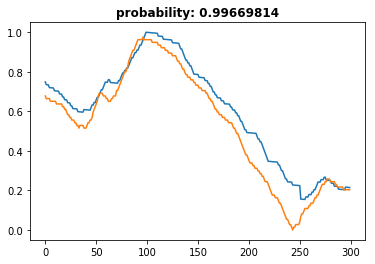

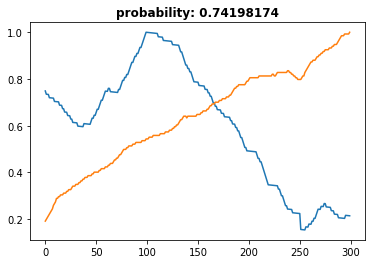

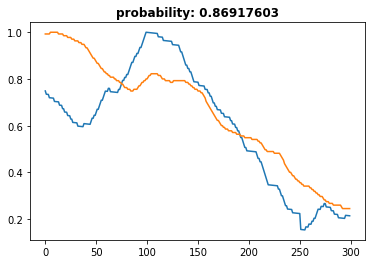

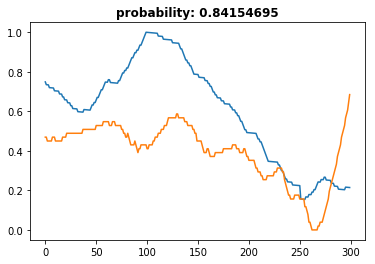

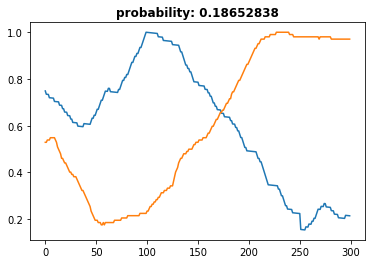

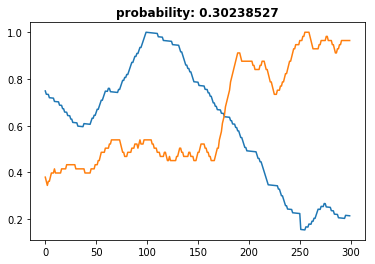

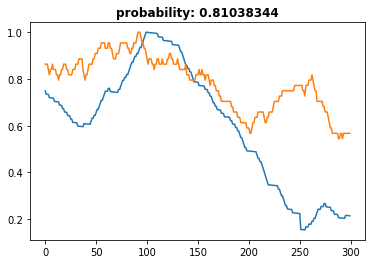

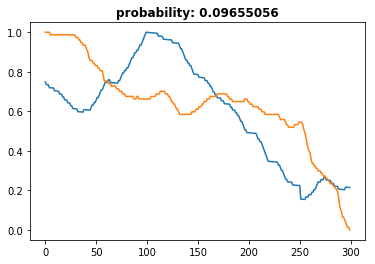

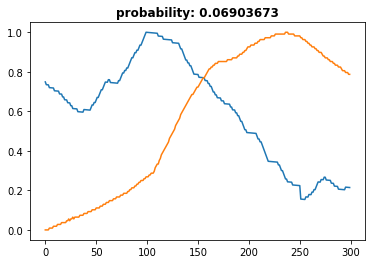

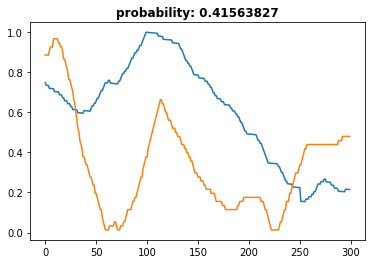

In [61]:
# line probability show
folder_dataset_test = SkylineDataset(root=Config.testing_dir, 
                                transform=transforms.Compose([ToTensor()]))
test_dataloader = DataLoader(folder_dataset_test,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
example0 = next(dataiter)
line0 = example0["line"][0].view(1, 1, -1)
line1 = example0["line"][1].view(1, 1, -1)
label = example0["label"].numpy()
print(label)
for i in range(10):
    output = model(Variable(line0).to(device),Variable(line1).to(device))
    line_show_test((line0, line1, label),'probability: {:.8f}'.format(output.item()))
    
    example1 = next(dataiter)
    line1 = example1["line"][1].view(1, 1, -1)

In [71]:
# acc inference
model.eval()

with torch.no_grad():
    filenames = os.listdir(Config.testing_dir)
    acc_top5 = 0
    acc_top10 = 0
    acc_top20 = 0
    acc_top50 = 0
    acc_top100 = 0
    acc_top200 = 0

    for i in trange(100):
        index_target = random.randint(0, len(filenames)-1)
        file0 = read_data_row(os.path.join(Config.testing_dir, filenames[index_target]), 1).strip().split(" ")
        line0 = np.array(list(map(int, file0[0].split(','))))
        dist = []
        for f in filenames:
            file1 = read_data_row(os.path.join(Config.testing_dir, f), 1).strip().split(" ")
            line1 = np.array(list(map(int, file1[1].split(','))))
            line = np.hstack((line0, line1))
            line_min, line_max = line.min(), line.max()
            line = (line-line_min)/(line_max-line_min)
            line1 = torch.from_numpy(line[:300].reshape(1, 1, -1))
            line2 = torch.from_numpy(line[300:].reshape(1, 1, -1))

            output = model(Variable(line1).float().to(device), Variable(line2).float().to(device))
            dist.append(output.item())

        dist = pd.Series(np.array(dist)).sort_values(ascending=False)
        if i == 0:
            print(index_target)
            print(dist)
        if index_target in dist[:5].index.tolist():
            acc_top5 += 1
        if index_target in dist[:10].index.tolist():
            acc_top10 += 1    
        if index_target in dist[:20].index.tolist():
            acc_top20 += 1
        if index_target in dist[:50].index.tolist():
            acc_top50 += 1    
        if index_target in dist[:100].index.tolist():
            acc_top100 += 1
        if index_target in dist[:200].index.tolist():
            acc_top200 += 1

    
    acc_top5 /= 100.0
    acc_top10 /= 100.0
    acc_top20 /= 100.0
    acc_top50 /= 100.0
    acc_top100 /= 100.0
    acc_top200 /= 100.0
    acc_mean = (acc_top5+acc_top10+acc_top20+acc_top50+acc_top100+acc_top200) / 6
    pf = 'acc_top5: %.3f |acc_top10: %.3f |acc_top20: %.3f | acc_top50: %.3f | acc_top100: %.3f | acc_top200: %.3f | acc_mean: %.3f'
    print(pf % ( acc_top5,
                 acc_top10,
                 acc_top20, 
                 acc_top50,
                 acc_top100,
                 acc_top200,
                 acc_mean))







  0%|          | 0/100 [00:00<?, ?it/s]




  1%|          | 1/100 [00:02<03:54,  2.37s/it]

938
662    0.957519
938    0.936669
894    0.919349
977    0.914375
641    0.891034
147    0.829033
812    0.823871
36     0.819366
33     0.804236
19     0.754277
346    0.752184
766    0.739946
628    0.724458
447    0.724269
215    0.709664
328    0.698312
430    0.679617
522    0.617538
889    0.611268
622    0.609487
62     0.583856
837    0.576792
881    0.555377
25     0.492627
214    0.429589
631    0.425378
639    0.423148
249    0.422168
507    0.419821
279    0.380263
         ...   
699    0.000004
290    0.000004
381    0.000004
315    0.000004
128    0.000004
990    0.000004
952    0.000004
281    0.000004
759    0.000004
937    0.000004
330    0.000004
932    0.000003
399    0.000003
6      0.000003
696    0.000003
369    0.000003
3      0.000003
499    0.000003
115    0.000003
64     0.000003
96     0.000003
222    0.000003
51     0.000003
593    0.000003
299    0.000002
994    0.000002
237    0.000002
466    0.000002
844    0.000002
887    0.000002
Length: 1000, dtype:






  2%|▏         | 2/100 [00:04<03:52,  2.37s/it]




  3%|▎         | 3/100 [00:07<03:50,  2.37s/it]




  4%|▍         | 4/100 [00:09<03:49,  2.39s/it]

KeyboardInterrupt: 